<a href="https://colab.research.google.com/github/tzurbar/046211/blob/main/Code/DINOv2_with_DORA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kornia

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [16]:
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
from torchvision.datasets import ImageFolder
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import time
import copy
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime
import kornia.augmentation as K

# Mount Google Drive
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Define transformations for data augmentation
torch.manual_seed(42)

transform = transforms.Compose([
    transforms.Resize((252, 252)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = ImageFolder(root='/content/drive/My Drive/046211/Project', transform=transform)

# Define the split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = int(0.1 * len(dataset))    # 10% for validation
test_size = len(dataset) - train_size - val_size  # remaining 10% for testing

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders for each split
train_loader = DataLoader(train_dataset, batch_size=264, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=264, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=264, shuffle=False)

# Print the sizes of each dataset
print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(val_dataset)}')
print(f'Test set size: {len(test_dataset)}')

Training set size: 21730
Validation set size: 2716
Test set size: 2717


In [10]:
class LowRankLayer(nn.Module):
    def __init__(self, linear, rank, alpha, use_dora=True):
        super().__init__()
        # rank: controls the inner dimension of the matrices A and B; controls the number of additional parameters introduced by LoRA,
        # a key factor in determining the balance between model adaptability and parameter efficiency.
        # alpha: a scaling hyper-parameter applied to the output of the low-rank adaptation,
        # controls the extent to which the adapted layer's output is allowed to influence the original output of the layer being adapted.

        self.use_dora = use_dora
        self.rank = rank  # low-rank
        self.alpha = alpha  # scaling hyper-parameter
        self.linear = linear
        self.in_dim = linear.in_features
        self.out_dim = linear.out_features

        # weights
        std_dev = 1 / torch.sqrt(torch.tensor(self.rank).float())
        self.A = nn.Parameter(torch.randn(self.in_dim, self.rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(self.rank, self.out_dim))

        if self.use_dora:
            self.m = nn.Parameter(
                self.linear.weight.norm(p=2, dim=0, keepdim=True))
        else:
            self.m = None

    def forward(self, x):
        lora = self.A @ self.B  # combine LoRA matrices
        if self.use_dora:
            numerator = self.linear.weight + self.alpha * lora.T
            denominator = numerator.norm(p=2, dim=0, keepdim=True)
            directional_component = numerator / denominator
            new_weight = self.m * directional_component
            return F.linear(x, new_weight, self.linear.bias)
        else:
            # combine LoRA with orig. weights
            combined_weight = self.linear.weight + self.alpha * lora.T
            return F.linear(x, combined_weight, self.linear.bias)

In [7]:
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs=25, device='cuda'):
    since = time.time()

    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Training phase
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # Backward pass + optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print('train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        # Validation phase
        model.eval()  # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            with torch.no_grad():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(val_dataloader.dataset)

        # Update the scheduler with the validation loss
        scheduler.step(epoch_loss)

        print('val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        val_loss_history.append(epoch_loss)
        val_acc_history.append(epoch_acc)

        # Deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, train_loss_history, val_acc_history, val_loss_history

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)
print(f"Original model: {model}")
# turn off gradients
model.requires_grad_(False)
rank = 4
alpha = 8
num_classes = 10
model.blocks[-1].mlp.fc2 = LowRankLayer(model.blocks[-1].mlp.fc2, rank, alpha, use_dora=True)
model.head = nn.Linear(384, num_classes)
print(f"After DoRA model: {model}")

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Original model: DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity(

In [14]:
# print and collect learnable paramters
print("Params to learn:")
params_to_update = []  # override the initial list definition above
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 blocks.11.mlp.fc2.A
	 blocks.11.mlp.fc2.B
	 blocks.11.mlp.fc2.m
	 head.weight
	 head.bias


In [ ]:
class AugmentedDataset(Dataset):
    def __init__(self, dataset, augmentations):
        self.dataset = dataset
        self.augmentations = augmentations
        self.to_tensor = transforms.ToTensor()
        self.resize = transforms.Resize((252, 252))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if not isinstance(image, torch.Tensor):
            image = self.to_tensor(image)
        image = self.resize(image)
        image = self.augmentations(image.unsqueeze(0)).squeeze(0)
        return image, label

In [ ]:
# Define Kornia augmentations
augmentations = nn.Sequential(
    K.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=(10, 10), p=0.5),
    K.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    K.RandomPerspective(0.5, p=0.5)
)

In [ ]:
# Apply augmentations to the dataset
augmented_trainset = AugmentedDataset(train_dataset, augmentations)

# Concatenate the original and augmented datasets
combined_trainset = ConcatDataset([train_dataset, augmented_trainset])

train_loader_combined = DataLoader(combined_trainset, batch_size=264, shuffle=True)


In [15]:
# hyper-parameters
num_epochs = 40
model = model.to(device)
# optimizer
optimizer_ft = torch.optim.Adam(params_to_update, lr=0.0003)
# loss function
criterion = nn.CrossEntropyLoss()
# Define scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.8, patience=5)

In [ ]:
# train
# Train and evaluate
model, train_acc_history, train_loss_history, val_acc_history, val_loss_history = train_model(model, train_loader_combined, val_loader, criterion, optimizer_ft, scheduler, num_epochs=num_epochs)

Epoch 0/39
----------
train Loss: 1.4689 Acc: 0.4867
val Loss: 1.0840 Acc: 0.5961

Epoch 1/39
----------
train Loss: 1.0235 Acc: 0.6168
val Loss: 0.9161 Acc: 0.6649

Epoch 2/39
----------
train Loss: 0.9193 Acc: 0.6530
val Loss: 0.8728 Acc: 0.6771

Epoch 3/39
----------
train Loss: 0.8616 Acc: 0.6772
val Loss: 0.8098 Acc: 0.7095

Epoch 4/39
----------
train Loss: 0.8250 Acc: 0.6896
val Loss: 0.7940 Acc: 0.7051

Epoch 5/39
----------
train Loss: 0.7985 Acc: 0.6992
val Loss: 0.7755 Acc: 0.7180

Epoch 6/39
----------
train Loss: 0.7780 Acc: 0.7083
val Loss: 0.7412 Acc: 0.7294

Epoch 7/39
----------
train Loss: 0.7612 Acc: 0.7139
val Loss: 0.7397 Acc: 0.7338

Epoch 8/39
----------
train Loss: 0.7491 Acc: 0.7172
val Loss: 0.7186 Acc: 0.7367

Epoch 9/39
----------
train Loss: 0.7370 Acc: 0.7223
val Loss: 0.7165 Acc: 0.7320

Epoch 10/39
----------
train Loss: 0.7278 Acc: 0.7256
val Loss: 0.6986 Acc: 0.7441

Epoch 11/39
----------
train Loss: 0.7212 Acc: 0.7284
val Loss: 0.7062 Acc: 0.7452

Ep

In [ ]:
# Get the current date and time
torch.save(model.state_dict(), f'/content/drive/My Drive/046211/Project/Dinov2_model_{timestamp}.pth')
# Create a DataFrame
# Ensure tensors are on CPU and converted to NumPy arrays
train_acc_history = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in train_acc_history]
train_loss_history = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in train_loss_history]
val_acc_history = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in val_acc_history]
val_loss_history = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in val_loss_history]

# Create a DataFrame
history_df = pd.DataFrame({
    'Epoch': range(1, len(train_acc_history) + 1),
    'Train_Acc': train_acc_history,
    'Train_Loss': train_loss_history,
    'Val_Acc': val_acc_history,
    'Val_Loss': val_loss_history
})

# Save to CSV
history_df.to_csv(f'/content/drive/My Drive/046211/Project/Dinov2_training_history_{timestamp}.csv', index=False)

In [ ]:
# Load from CSV
history_df = pd.read_csv(f'/content/drive/My Drive/046211/Project/Dinov2_training_history_{timestamp}.csv')

train_acc_history = history_df['Train_Acc'].tolist()
train_loss_history = history_df['Train_Loss'].tolist()
val_acc_history = history_df['Val_Acc'].tolist()
val_loss_history = history_df['Val_Loss'].tolist()

In [ ]:
def plot_training_history(train_acc_history, val_acc_history, train_loss_history, val_loss_history):
    epochs = range(1, len(train_acc_history) + 1)

    plt.figure(figsize=(12, 6))

    # Subplot 1: Training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc_history, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc_history, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Subplot 2: Training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss_history, 'b', label='Training loss')
    plt.plot(epochs, val_loss_history, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Create filename with name, date, and time
    filename = f'/content/drive/My Drive/046211/Project/Dinov2_training_history_{timestamp}.png'

    # Save to PNG
    plt.savefig(filename, format='png')
    plt.tight_layout()
    plt.show()

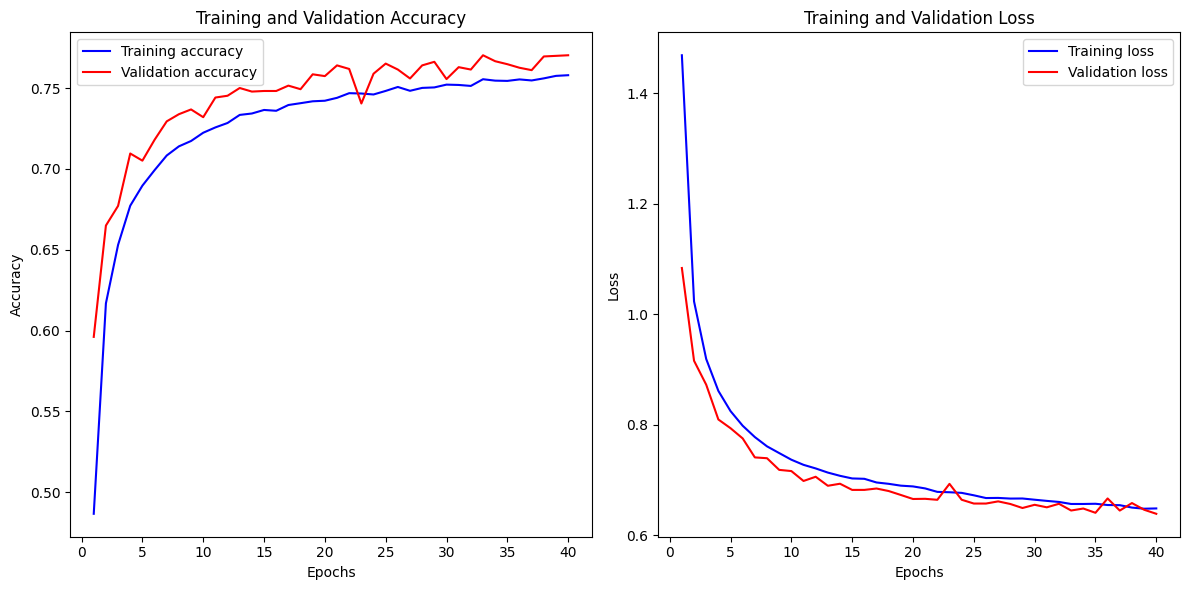

In [ ]:
plot_training_history(train_acc_history, val_acc_history, train_loss_history, val_loss_history)

In [17]:
def evaluate_model_with_confusion_matrix(model, test_dataloader, criterion, device='cuda'):
    model.eval()  # Set model to evaluation mode

    all_labels = []
    all_preds = []

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

        # Collect all labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(test_dataloader.dataset)
    epoch_acc = running_corrects.double() / len(test_dataloader.dataset)

    print('Test Loss: {:.4f} | Test Accuracy: {:.4f}'.format(epoch_loss, epoch_acc))

    # Retrieve class names from the Dataset object
    class_names = test_dataloader.dataset.dataset.classes

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=list(range(len(class_names))))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Calculate and print accuracy
    accuracy = accuracy_score(all_labels, all_preds) * 100
    print("Accuracy of the Model: {:.1f}%".format(accuracy))

    return epoch_loss, epoch_acc, conf_matrix

Test Loss: 0.6456 | Test Accuracy: 0.7733


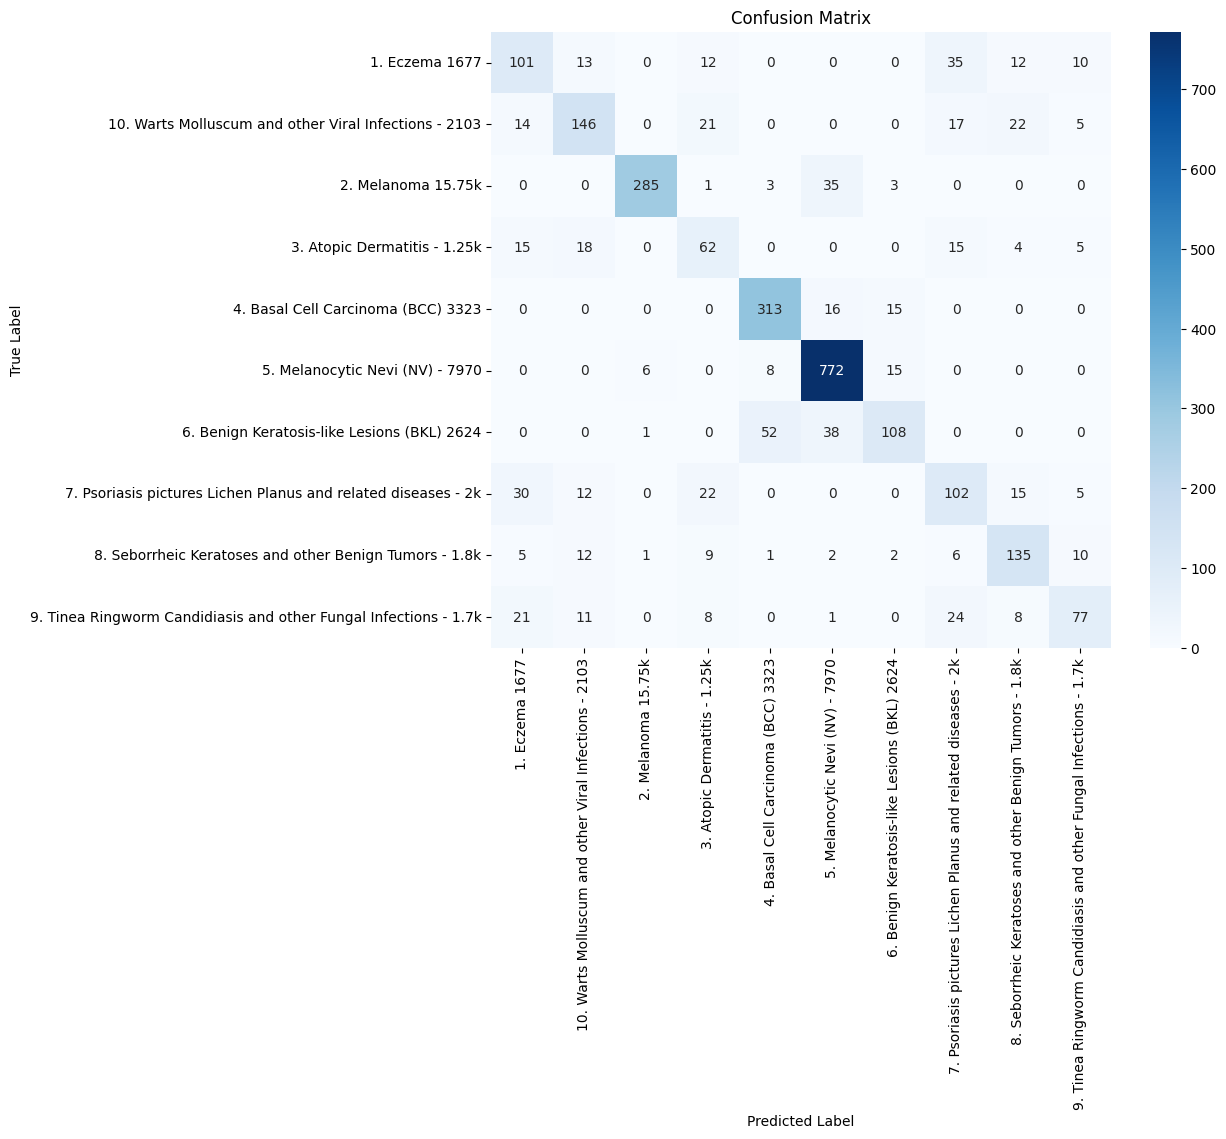


Classification Report:

                                                                  precision    recall  f1-score   support

                                                  1. Eczema 1677       0.54      0.55      0.55       183
           10. Warts Molluscum and other Viral Infections - 2103       0.69      0.65      0.67       225
                                              2. Melanoma 15.75k       0.97      0.87      0.92       327
                                    3. Atopic Dermatitis - 1.25k       0.46      0.52      0.49       119
                              4. Basal Cell Carcinoma (BCC) 3323       0.83      0.91      0.87       344
                                 5. Melanocytic Nevi (NV) - 7970       0.89      0.96      0.93       801
                     6. Benign Keratosis-like Lesions (BKL) 2624       0.76      0.54      0.63       199
   7. Psoriasis pictures Lichen Planus and related diseases - 2k       0.51      0.55      0.53       186
          8. Seborrh

In [18]:
model.load_state_dict(torch.load(f'/content/drive/My Drive/046211/Project/Dinov2_model_2024-08-08_11-17-15.pth'))
test_loss, test_acc, conf_matrix = evaluate_model_with_confusion_matrix(model, test_loader, criterion, device='cuda')
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")